<div style="text-align: center;">
    <img src="logoucm.png" style="height: 250px;">
    <br/>
    <span style="color:#888"></span>
</div>





<font size="6"><center>***Metodos numéricos en finanzas***</center></font>

<font size="5"><center><span style="color:blue">***Nombre y Apellidos: Andrés Velasco Sánchez***</span></center></font>

## Importamos las librerías necesarias

In [97]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, log, exp, pi
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import t
import scipy.stats as si

In [98]:
M=2**(31)-1
A=16807
B=0

In [99]:
def imprimir_tabla_estadisticas(df):
    print("\n" + "="*75)
    print("      RESULTADOS MONTE CARLO - OPCION CALL EUROPEA VAINILLA")
    print("="*75)
    print(f"{'Plazos':<10} | {'Valor estimado':>15} | {'Varianza':>15} | {'Precisión (95%)':>18}")
    print("-"*75)

    for _, row in df.iterrows():
        print(f"{row['Plazo']:<10} | "
              f"{row['Valor estimado']:>15.6f} | "
              f"{row['Varianza']:>15.6f} | "
              f"{row['Precisión (95%)']:>18.6f}")

    print("="*75 + "\n")


def calcular_estadisticas_montecarlo(valores):
    n_muestras = len(valores)
    media = np.mean(valores)
    varianza = np.var(valores, ddof=1)
    desviacion_std = np.std(valores, ddof=1)
    t_critico = t.ppf(0.975, df=n_muestras - 1)

    precision = t_critico * (desviacion_std / sqrt(n_muestras))

    return media, varianza, precision


def generador_congruencial(semilla, m, a, b):
    x = semilla
    inv_m = 1 / m
    while True:
        x = (a * x + b) % m
        yield x * inv_m
def box_muller(N,ant=False):
    g_2 = generador_congruencial(123456789, M, A, B)
    n = N * 2
    U = [1 - next(g_2) if ant else next(g_2) for _ in range(n)]
    u1 = np.array(U[0::2])
    u2 = np.array(U[1::2])

    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(2.0 * np.pi * u2)
    return z0, z1


def marsaglia_method(N,ant=False):
    g_3 = generador_congruencial(123456789, M, A, B)
    X = []
    Y = []
    n = 0
    while n<N:
        U_1 = 1-next(g_3) if ant else next(g_3)
        U_2 = 1-next(g_3) if ant else next(g_3)
        v_1 = 2 * U_1 - 1
        v_2 = 2 * U_2 - 1
        R_2 = v_1**2 + v_2**2
        if R_2 >= 1:
            continue

        y = np.sqrt(-2 * np.log(R_2) / R_2)
        X.append(v_1 * y)
        Y.append(v_2 * y)
        n += 1

    return np.array(X), np.array(Y)

def brownian_motion(T, N,X,Y):
    dt = T / N
    X = [0]+X.tolist()
    Y = [0]+Y.tolist()
    X = np.cumsum(np.sqrt(dt) * np.array(X))
    Y = np.cumsum(np.sqrt(dt) * np.array(Y))
    return X, Y


def Gamma(p,a,N):
    g_3 = generador_congruencial(123456789, M, A, B)
    X = []
    n=0
    while n < N:
        u = np.zeros(p)
        suma = 0
        for i in range(p):
            v = next(g_3)
            u[i] = log(v)
    
        x = -sum(u)/a
        X.append(x)
        n+=1
    return np.array(X)

def chi_cuadrado(n,N):
    if n%2==0:
        X = Gamma(int(n/2),1/2,N)
        return np.array(X)
    else:
        x = Gamma(int((n-1))/2,1/2,N)
        y,Z= box_muller(N)
        X = x + Z**2
        return X
    
def t_Student(n,N):
    x,Z = box_muller(N)
    Y = chi_cuadrado(n,N)
    X = Z/np.sqrt(Y/n)
    return X
def ecuacion_estocastica(S0, r, d, sigma, T,Z_n, dt=1/12, N_caminos=100):
    M = int(T / dt)  
    Z_n = Z_n.reshape(N_caminos, M)
    multipliers=(1+r-d)**dt+sigma*np.sqrt(dt)*Z_n

    ST= S0*np.prod(multipliers, axis=1)

    return ST


<font size="6"><center><span style="color:blue">***Práctica 3***</span></center></font>

Obtener mediante simulación el valor de una opción call europea vainilla con dividendos para plazos t=1,2,...,T, pero cuyos incrementos se rigen según una distribución t-Student. Dar la estimación del valor y la precisión y comparar con el resultado de la práctica anterior. Utilizar los mismos datos que en la práctica anterior y n=6. Utilizar para la evolución del subyacente:

$$
S \leftarrow S e^{(r_c - d_c)\Delta t} + \sigma S \sqrt{\Delta t}\frac{t_n}{\sqrt{n/(n-2)}}
$$

<font size="2">**Nota:** Recordar que la varianza de una t-Student con n grados de libertad es $\frac{n}{n-2}$, con lo que al sustituir la Normal por la t-Student, ha de hacerse con ésta tipificada.
    
<font size="2" color=grey>**Nota para comprobación:** $t=1; V_{\mathrm{call}}=1.840173;Varianza=8.169188;Precisión=0.177363$.</font>

In [100]:

r = 0.03
r_c = log(1+r)
K = 14
T = 1
sigma = 0.3
S0 = 14
d_c = 0
d=0
N = 1000
n=6
delta_t = 1/12

def vainilla(r_c,d_c,plazos,delta_t,S0,n,N):
    #t = t_Student(n, int(N*(plazos/delta_t)))
    t = si.t.rvs(df=n, size=int(N*(plazos/delta_t)), random_state=42)
    t = t.reshape(N, int(plazos/delta_t))
    multiplicadores = exp((r_c-d_c)*delta_t) + sigma  * sqrt(delta_t)*(t/(sqrt(n/(n-2))))
    ST= S0*np.prod(multiplicadores, axis=1)
    return ST
plazos = [1,2,3,4]



In [101]:


df = pd.DataFrame([{        "Plazo": int(i),
        "Valor estimado": calcular_estadisticas_montecarlo(exp(-r_c*T) * np.maximum(vainilla(r_c,d_c, i,delta_t,S0,n,N)-K, 0))[0],
        "Varianza": calcular_estadisticas_montecarlo(exp(-r_c*T) * np.maximum(vainilla(r_c,d_c, i,delta_t,S0,n,N)-K, 0))[1],
        "Precisión (95%)": calcular_estadisticas_montecarlo(exp(-r_c*T) * np.maximum(vainilla(r_c,d_c, i,delta_t,S0,n,N)-K, 0))[2]}for i in plazos ])

imprimir_tabla_estadisticas(df)


      RESULTADOS MONTE CARLO - OPCION CALL EUROPEA VAINILLA
Plazos     |  Valor estimado |        Varianza |    Precisión (95%)
---------------------------------------------------------------------------
1.0        |        1.747598 |        8.558906 |           0.181545
2.0        |        2.767836 |       24.192178 |           0.305219
3.0        |        3.618199 |       41.791753 |           0.401162
4.0        |        4.015733 |       57.275790 |           0.469635



## Comparación con la Práctica 2

Para comparar los resultados de la **Práctica 3** con los de la **Práctica 2**, se consideran los siguientes esquemas de simulación del subyacente:

### Práctica 2 – Apartado (b.3): Incrementos normales

La evolución del precio del subyacente se obtiene mediante el siguiente mecanismo de transición, usando incrementos normales:

$$
S \leftarrow S(1+r-d)^{\Delta t}
+ \sigma S \sqrt{\Delta t}\,\mathcal N(0,1)
$$

donde $\mathcal N(0,1)$ denota una variable aleatoria Normal estándar.

### Práctica 3: Incrementos t-Student

En la Práctica 3, la evolución del subyacente se simula sustituyendo los incrementos normales por una distribución t-Student con $n = 6$ grados de libertad, tipificada para mantener varianza unitaria:

$$
S \leftarrow S e^{(r_c - d_c)\Delta t}
+ \sigma S \sqrt{\Delta t}\,
\frac{t_n}{\sqrt{n/(n-2)}}
$$

donde $t_n$ representa una variable aleatoria con distribución t-Student con $n$ grados de libertad.

### Resultados para $t = 1$

| Modelo | Valor Call | Varianza | Precisión |
|------|-----------|----------|-----------|
| Normal (Práctica 2, b.3) | 2.005745 | 10.020386 | 0.196434 |
| t-Student (Práctica 3, n = 6) | 1.747598 | 8.558906| 0.181545 |




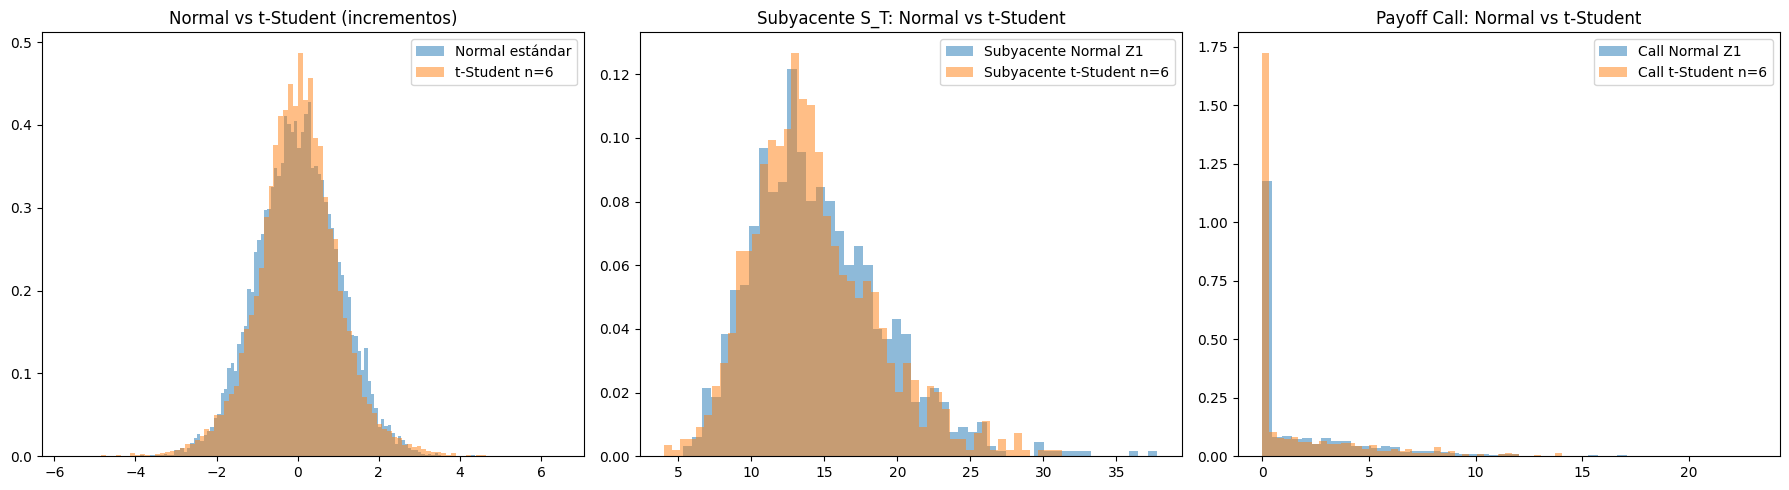

In [114]:

Z0, Z1 = box_muller(int(N*(1/delta_t)))
t_student_6 = t.rvs(df=n, size=int(N*(1/delta_t)))
t_student_6 = t_student_6 / np.sqrt(n/(n-2))

S_T = ecuacion_estocastica(S0, r_c, d_c, sigma, T, Z1, N_caminos=N)
S_student = vainilla(r_c, d_c, T, delta_t, S0, n, N)

V_call_Z = np.exp(-r_c*T) * np.maximum(S_T - K, 0)
V_call_student = np.exp(-r_c*T) * np.maximum(S_student - K, 0)


fig, axes = plt.subplots(1, 3, figsize=(18,5))

axes[0].hist(Z1, bins=100, density=True, alpha=0.5, label="Normal estándar")
axes[0].hist(t_student_6, bins=100, density=True, alpha=0.5, label="t-Student n=6")
axes[0].set_title("Normal vs t-Student (incrementos)")
axes[0].legend()

axes[2].hist(V_call_Z, bins=50, density=True, alpha=0.5, label='Call Normal Z1')
axes[2].hist(V_call_student, bins=50, density=True, alpha=0.5, label='Call t-Student n=6')
axes[2].set_title("Payoff Call: Normal vs t-Student")
axes[2].legend()


axes[1].hist(S_T, bins=50, density=True, alpha=0.5, label='Subyacente Normal Z1')
axes[1].hist(S_student, bins=50, density=True, alpha=0.5, label='Subyacente t-Student n=6')
axes[1].set_title("Subyacente S_T: Normal vs t-Student")
axes[1].legend()

plt.tight_layout()
plt.show()


### Comentario

La utilización de una distribución t-Student introduce **colas más pesadas** (como podemos observar en la gráfica de arriba), lo que incrementa la probabilidad de movimientos extremos del subyacente. Como consecuencia, el valor estimado de la opción call resulta inferior al obtenido bajo el supuesto de normalidad, observándose además una ligera mejora en la precisión de la estimación.